In [1]:
!pip install networkx

In [2]:
import datetime
import functools
import itertools
from pathlib import Path
from timeit import default_timer

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [3]:
%matplotlib notebook
pd.options.display.float_format = '{:.2f}'.format

In [10]:
!cd ../data; python3 preprocess.py

<class 'pandas.core.frame.DataFrame'>
Index: 70 entries, GotPdi7ND5U93CiLruCUjAPr0R5af8PkKEZQ9UJHNlE= to 8K26YsyMwaxAbofr9cYRDbjIDwf5kYJkp1FqGZB+A=
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   user_display_name         70 non-null     object
 1   user_screen_name          70 non-null     object
 2   user_reported_location    25 non-null     object
 3   user_profile_description  27 non-null     object
 4   user_profile_url          4 non-null      object
 5   follower_count            70 non-null     int64 
 6   following_count           70 non-null     int64 
 7   account_creation_date     70 non-null     object
 8   account_language          70 non-null     object
 9   campaign                  70 non-null     object
 10  release                   70 non-null     object
 11  government                70 non-null     object
 12  file                      70 non-null     object
dtypes: i

In [117]:
campaigns = ['GRU202012']
ts = datetime.datetime.now()
name = '{}_{}'.format(campaigns, ts)

log = []
log.append('Datasets: {}\n'.format(campaigns))

users_combined = pd.read_csv('../data/users_combined.csv',
                             index_col='userid',
                             low_memory=False)
tweets_combined = pd.read_csv('../data/tweets_combined.csv',
                              index_col='tweetid',
                              low_memory=False)

users = users_combined.loc[:][users_combined['campaign'].isin(campaigns)]
tweets = tweets_combined.loc[:][tweets_combined['campaign'].isin(campaigns)]

tweets_dtypes = {
    'user_display_name':'string',
    'user_screen_name':'string',
    'user_reported_location':'string',
    'user_profile_description':'string',
    'user_profile_url':'string',
    'account_creation_date':'datetime64',
    'account_language':'string',
    'tweet_language':'string',
    'tweet_text':'string',
    'tweet_time':'datetime64',
    'tweet_client_name':'category',
    'latitude':'category',
    'longitude':'category',
    'campaign':'string',
    'government':'string',
    'file':'string'}
users_dtypes = {
    'user_display_name':'string',
    'user_screen_name':'string',
    'user_reported_location':'string',
    'user_profile_description':'string',
    'user_profile_url':'string',
    'follower_count':'int64',
    'following_count':'int64',
    'account_creation_date':'datetime64',
    'account_language':'string',
    'campaign':'string',
    'government':'string',
    'file':'string'}

tweets = tweets.astype(tweets_dtypes)
users = users.astype(users_dtypes)

# 3. User Graph Construction

For each dataset, create a script that generates a graph representation
where users are nodes and edges are tweets shared between users in the campaign.

Relationships users can have with tweets:
- author
- like
- quote
- retweet
- reply

Relationships users can have with users:
- replied to
- quoted
- retweeted

Relationships tweets can have with tweets (tweet x {} tweet y):
- quotes
- retweets
- replies

In [251]:
ls = list(zip(['tweetid' for i in range(len(retweets.index))], retweets.index))

In [242]:
retweets = tweets[tweets['is_retweet'] == 'True']
retweet_edges = list(zip(retweets['userid'], retweets['retweet_userid']))
retweets_graph = nx.DiGraph()
retweets_graph.add_edges_from(retweet_edges)

In [227]:
replies = tweets[tweets['in_reply_to_tweetid'].notna()]
reply_edges = list(zip(replies['userid'], replies['in_reply_to_tweetid']))
reply_edges = dict(zip(reply_edges, replies.index))
replies_graph = nx.DiGraph()
replies_graph.add_edges_from(reply_edges)

In [223]:
user_tweets = tweets.groupby('userid')
max_user = user_tweets.size().idxmax()

In [224]:
retweets_graph.out_degree(max_user)

8

In [225]:
list(retweets_graph.successors(max_user))

[nan,
 'XY8GkjD7wdwBUNuKQguI7S9m6N4ynAjrOoBdReCxvI=',
 'oX70apRWUW16BANgrVbdK+UVxH0NdxvC9b4HHO+aA9Y=',
 '9zxsi+qIsPp4ZaNFZCxaLJIePPypzDuzVZg97pJfU=',
 '3PGzTwb+Kk4yCSOyqgAZ3zPaUJ7xE3L+BSppo6ZLw8U=',
 '883565926473486336',
 '849852472915046400',
 '135AEY00MOP1tH7YCuKyQx2xM0hG1vsl7l+0QPTliyM=']

In [228]:
len(list(replies_graph.successors(max_user)))

1286

In [229]:
list(retweets_graph.neighbors(max_user))

[nan,
 'XY8GkjD7wdwBUNuKQguI7S9m6N4ynAjrOoBdReCxvI=',
 'oX70apRWUW16BANgrVbdK+UVxH0NdxvC9b4HHO+aA9Y=',
 '9zxsi+qIsPp4ZaNFZCxaLJIePPypzDuzVZg97pJfU=',
 '3PGzTwb+Kk4yCSOyqgAZ3zPaUJ7xE3L+BSppo6ZLw8U=',
 '883565926473486336',
 '849852472915046400',
 '135AEY00MOP1tH7YCuKyQx2xM0hG1vsl7l+0QPTliyM=']

In [179]:
retweets_graph.in_degree(max_user)

11

In [181]:
replies_graph.out_degree(max_user)

1286

In [183]:
replies_graph.in_degree(max_user)

0

<IPython.core.display.Javascript object>


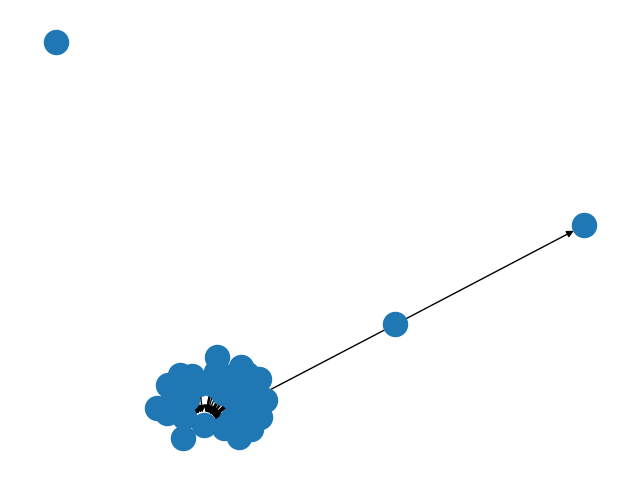

In [263]:
plt.figure()
nx.draw(retweets_graph)
plt.show()

In [184]:
# retweets between users identified with the campaign
inside_rt = tweets[tweets['retweet_userid'].isin(users.index)]
in_rt_edges = list(zip(inside_rt['userid'], inside_rt['retweet_userid']))

In [185]:
# replies between users identified with the campaign
inside_replies = tweets[tweets['in_reply_to_userid'].isin(users.index)]
inside_reply_edges = list(zip(inside_replies['userid'], inside_replies['in_reply_to_userid']))

### Hub identification: 

For each graph, rank users by activity: users that create or propagate most
of the tweets rank higher. Create 3 lists: most creators, most propagators, users who do both!

In [253]:
rt_degrees = sorted(d for n, d in retweets_graph.out_degree())
rt_degrees[-1]

8

<IPython.core.display.Javascript object>


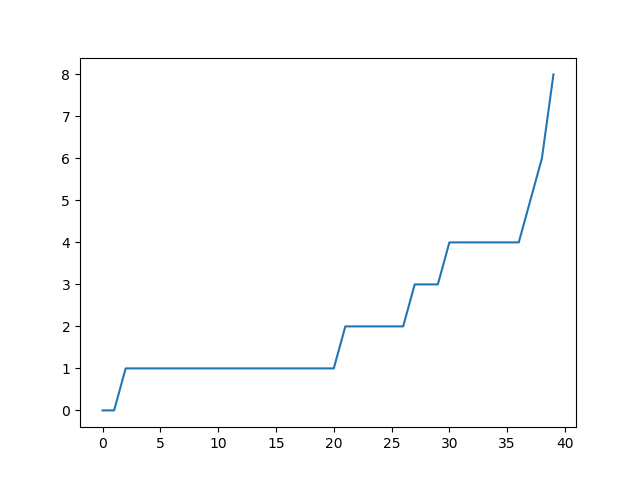

In [254]:
plt.figure()
plt.plot(rt_degrees)
plt.show()

In [255]:
replies_by_degree = sorted(d for n, d in replies_graph.out_degree())
replies_by_degree[-1]

1286

<IPython.core.display.Javascript object>


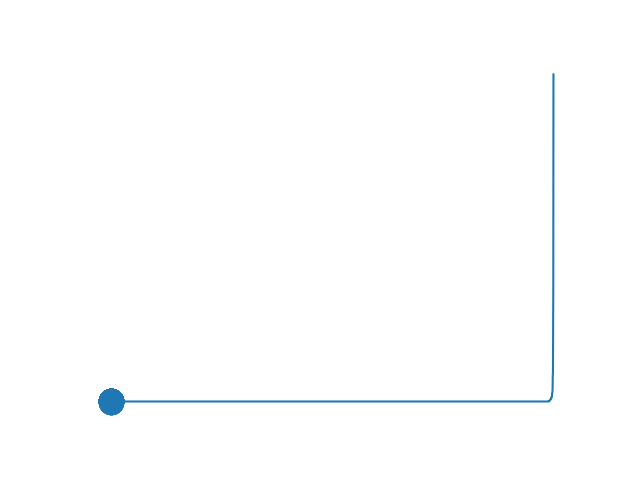

In [258]:
plt.figure()
plt.plot(replies_by_degree)
plt.show()

In [257]:
sorted(replies_by_degree, reverse=True)[:25]

[1286,
 448,
 326,
 114,
 104,
 52,
 37,
 34,
 31,
 20,
 18,
 16,
 16,
 14,
 12,
 12,
 9,
 8,
 7,
 6,
 5,
 4,
 4,
 4,
 3]